In [12]:
from typing import Annotated, Literal, List, Dict, Any
import os
import sys
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import time
import getpass
from datetime import datetime, timedelta

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END, StateGraph, START
from langgraph.types import Command

import io
import base64
from contextlib import redirect_stdout


def _set_if_undefined(var : str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")    

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

delay_input = input("Enter delay between agent calls in seconds (default is 60): ")
if delay_input.strip() == "":
    DELAY_SECONDS = 60
else:
    try:
        DELAY_SECONDS = float(delay_input)
    except ValueError:
        print("Invalid input. Using default delay of 60 seconds.")
        DELAY_SECONDS = 60

token_input = input("Enter max token limit for LLM agents (default is 1500): ")
if token_input.strip() == "":
    max_tokens = 1500
else:
    try:
        max_tokens = int(token_input)
    except ValueError:
        print("Invalid input. Using default token limit of 1500.")
        max_tokens = 1500

print(f"Using delay: {DELAY_SECONDS} seconds")
print(f"Using max token limit: {max_tokens}")

Enter delay between agent calls in seconds (default is 60):  60
Enter max token limit for LLM agents (default is 1500):  1500


Using delay: 60.0 seconds
Using max token limit: 1500


In [13]:
tavily_tool = TavilySearchResults(max_results=3)
repl = PythonREPL()


In [14]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate charts or analyze data."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. Ensure plt.close() is utilized after each chart to clean it up"""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
@tool
def yahoo_finance_tool(
    ticker: Annotated[str, "The stock ticker symbol to look up"],
    period: Annotated[str, "Time period to fetch data for (e.g., '1y', '6mo', '1mo')"] = "1y",
    metrics: Annotated[str, "Comma-separated list of metrics to retrieve (e.g., 'price,dividends,financials')"] = "price,info"
):
    """Use this to get financial data for a specific stock ticker from Yahoo Finance.
    Commonly used periods: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
    Common metrics: price, info, financials, balance_sheet, cashflow, dividends, splits, actions, sustainability
    """
    try:
        stock = yf.Ticker(ticker)
        results = {}
        
        metric_list = [m.strip() for m in metrics.split(',')]
        
        if 'price' in metric_list:
            results['price_data'] = stock.history(period=period).to_dict(orient='records')
            
        if 'info' in metric_list:
            results['info'] = stock.info
            
        if 'financials' in metric_list:
            results['financials'] = stock.financials.to_dict()
            
        if 'balance_sheet' in metric_list:
            results['balance_sheet'] = stock.balance_sheet.to_dict()
            
        if 'cashflow' in metric_list:
            results['cashflow'] = stock.cashflow.to_dict()
            
        if 'dividends' in metric_list:
            results['dividends'] = stock.dividends.to_dict()
            
        return results
        
    except Exception as e:
        return f"Error fetching data for {ticker}: {str(e)}"


In [15]:
def make_system_prompt(role_description: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other specialized assistant agents "
        "as part of a stock analysis team. "
        "Use the provided tools to progress towards selecting and analyzing the top 2 most promising stocks. "
        f"\n\n{role_description}\n\n"
        "If you or any of the other assistants have completed your specific task, "
        "prefix your response with TASK COMPLETE so the team knows to move to the next stage. "
        "ONLY the REPORT AGENT should ever use FINAL ANSWER when the final report is complete."
    )

In [16]:
model_name = os.environ.get("MODEL_NAME", "gpt-4o-mini")
print(f"Using LLM model: {model_name}")
llm = ChatOpenAI(model=model_name,
                 max_tokens=max_tokens)

research_llm = ChatOpenAI(
    model=model_name,
    max_tokens=max_tokens
)



Using LLM model: gpt-4o-mini


In [17]:
research_agent = create_react_agent(
    research_llm, 
    [tavily_tool, yahoo_finance_tool],
    prompt=make_system_prompt(
        "You are the RESEARCH AGENT. You are responsible for both planning and executing research on promising stocks. "
        "First, develop a research strategy to identify promising stocks based on financial performance, growth potential, "
        "market conditions, and industry trends. Then execute that plan by using the Tavily search tool for market research "
        "and the Yahoo Finance tool to gather specific stock data. "
        "Collect comprehensive information on promising stocks, including financial metrics, recent performance, "
        "analyst opinions, and market trends."
        "Organize your findings clearly to help the DECISION MAKER select the top 2 stocks."
    ),
)

decision_maker_agent = create_react_agent(
    llm,
    [yahoo_finance_tool],
    prompt=make_system_prompt(
        "You are the DECISION MAKER AGENT. Your job is to analyze the research provided and select the 2 most "
        "promising stocks. Base your decision on factors like growth potential, financial health, competitive "
        "advantage, and market conditions. Work together with the RESEARCH AGENT and request "
        "research from the RESEARCH AGENT by including 'RESTART RESEARCH' in your response. Do this until you can make a confident decision"
        "to find the best stocks. Once you've made your final selection of the top 2 stocks, include 'DECISION COMPLETE' in your "
        "response to indicate you have finalized your choices, and provide clear reasoning for your selections."
    ),
)

chart_generator_agent = create_react_agent(
    llm,
    [python_repl_tool, yahoo_finance_tool],
    prompt=make_system_prompt(
        "You are the CHART GENERATOR AGENT. You create insightful visualizations of stock data to enhance "
        "the final report. When requested by the REPORT AGENT, generate clear and informative charts such as "
        "price trends, comparative performance, financial metrics, or any other relevant visualizations. "
        "Use Python with libraries like matplotlib, seaborn, or plotly to create professional-quality charts. "
        "Always focus on creating visualizations that tell a meaningful story about why these stocks are promising. "
        "After you've generated all requested charts, include 'TASK COMPLETE' in your response. "
        "Do NOT include 'FINAL ANSWER' as that should only come from the REPORT AGENT."
    ),
)

report_agent = create_react_agent(
    llm,
    [], 
    prompt=make_system_prompt(
        "You are the REPORT AGENT. Your job is to create a comprehensive final report on the  most promising "
        "stocks selected by the DECISION MAKER. Structure your report with clear sections covering each stock's "
        "background, financial performance, growth potential, risks, and investment thesis. "
        "ALWAYS include charts to visualize data by including 'NEED CHARTS' and specifying exactly what charts you want created. "
        "After receiving charts from the CHART GENERATOR, incorporate them into your analysis. "
        "When your report is complete with all necessary charts and analysis, prefix your response with 'FINAL ANSWER' "
        "to indicate the workflow is complete. Your final report should be detailed, well-organized, and provide "
        "clear rationale for why these stocks are considered promising investments."
    ),
)

In [18]:
def research_node(state: MessagesState):
    """Node for the research agent."""
    print("Research agent starting...")
    time.sleep(DELAY_SECONDS) 
    result = research_agent.invoke(state)
    print("Research agent finished.")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="research_agent"
    )
    return {"messages": result["messages"]}

def decision_maker_node(state: MessagesState):
    """Node for the decision maker agent."""
    print("Decision maker agent starting...")
    time.sleep(DELAY_SECONDS)
    result = decision_maker_agent.invoke(state)
    print("Decision maker agent finished.")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="decision_maker_agent"
    )
    return {"messages": result["messages"]}

def chart_generator_node(state: MessagesState):
    """Node for the chart generator agent."""
    print("Chart generator agent starting...")
    time.sleep(DELAY_SECONDS) # delay to prevent rate limits
    result = chart_generator_agent.invoke(state)
    print("Chart generator agent finished.")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator_agent"
    )
    return {"messages": result["messages"]}

def report_node(state: MessagesState):
    """Node for the report agent."""
    print("Report agent starting...")
    time.sleep(DELAY_SECONDS)  # Add delay before API call
    result = report_agent.invoke(state)
    print("Report agent finished.")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="report_agent"
    )
    return {"messages": result["messages"]}

# Define routing conditions
def should_restart_research(state: MessagesState) -> bool:
    """Check if research should be restarted based on decision maker's response."""
    if not state["messages"]:
        return False
    last_message = state["messages"][-1]
    return "RESTART RESEARCH" in last_message.content

def is_decision_complete(state: MessagesState) -> bool:
    """Check if decision making is complete."""
    if not state["messages"]:
        return False
    last_message = state["messages"][-1]
    return "DECISION COMPLETE" in last_message.content

def needs_charts(state: MessagesState) -> bool:
    """Check if report needs charts."""
    if not state["messages"]:
        return False
    last_message = state["messages"][-1]
    return "NEED CHARTS" in last_message.content

def is_final_answer(state: MessagesState) -> bool:
    """Check if report is complete with final answer."""
    if not state["messages"]:
        return False
    last_message = state["messages"][-1]
    return "FINAL ANSWER" in last_message.content

def is_task_complete(state: MessagesState) -> bool:
    """Check if chart generation is complete."""
    if not state["messages"]:
        return False
    last_message = state["messages"][-1]
    return "TASK COMPLETE" in last_message.content

def decision_maker_router(state: MessagesState) -> str:
    """Route from decision maker node."""
    # If decision is complete, go to report, otherwise back to research
    if is_decision_complete(state):
        return "report"
    else:
        return "research"

def report_router(state: MessagesState) -> str:
    """Route from report node."""
    # If report has final answer, end the workflow
    # Otherwise, go to chart generator
    if needs_charts(state):
        return "chart_generator"
    if is_final_answer(state):
        return END
    else:
        return "chart_generator"

In [19]:
# Create state graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("research", research_node)
workflow.add_node("decision_maker", decision_maker_node)
workflow.add_node("chart_generator", chart_generator_node)
workflow.add_node("report", report_node)

# Add edges with conditions
workflow.add_edge(START, "research")
workflow.add_edge("research", "decision_maker")
workflow.add_conditional_edges(
    "decision_maker",
    decision_maker_router,
    {
        "report": "report",
        "research": "research",
    }
)
workflow.add_conditional_edges(
    "report",
    report_router,
    {
        "chart_generator": "chart_generator",
        "__end__": END,
    }
)
workflow.add_edge("chart_generator", "report")

# Compile the graph
graph = workflow.compile()

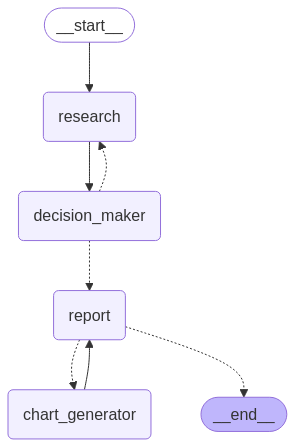

In [20]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Research agent starting...
Research agent finished.
Decision maker agent starting...
Decision maker agent finished.
Report agent starting...
Report agent finished.
Chart generator agent starting...


Python REPL can execute arbitrary code. Use with caution.
Python REPL can execute arbitrary code. Use with caution.
Python REPL can execute arbitrary code. Use with caution.
<string>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
<string>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
<string>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
<string>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
<string>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


Chart generator agent finished.
Report agent starting...
Report agent finished.

===FINAL RESULT ===
{'report': {'messages': [HumanMessage(content='Please identify the top 2 most promising stocks for long-term growth investment, research them thoroughly, and provide a detailed report with supporting visualizations.', additional_kwargs={}, response_metadata={}, id='1855ef38-c23f-43f1-b7fa-d0f098456606'), AIMessage(content='### Research Strategy for Identifying Promising Stocks\n\nTo identify the top 2 stocks for long-term growth investment, we will focus on the following criteria:\n\n1. **Financial Performance**: Analyze key financial metrics such as revenue growth, profit margins, earnings per share (EPS), and return on equity (ROE) over the past few years.\n\n2. **Growth Potential**: Examine companies with strong historical growth rates and positive growth forecasts based on analyst opinions and market research.\n\n3. **Market Conditions**: Assess current market trends and economic co

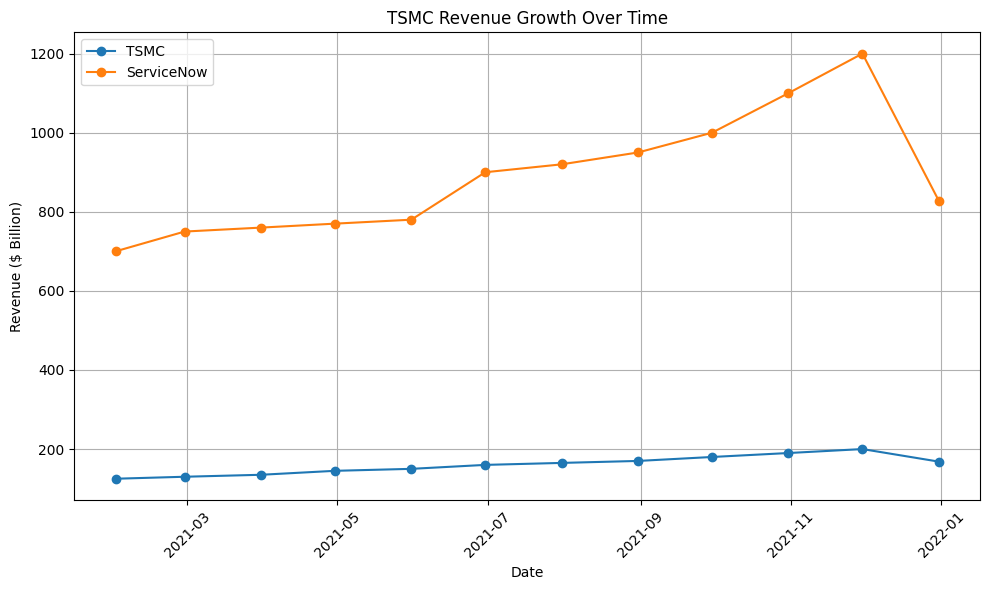

In [21]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Please identify the top 2 most promising stocks for long-term growth investment, "
                "research them thoroughly, and provide a detailed report with supporting visualizations."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)

last_result = None
for s in events:
    last_result = s
if last_result:
    print("\n===FINAL RESULT ===")
    print(s)
    print("---")